# Easy 21: control

## Implementation of Easy21 simulator

The following is an implementation of the _Easy21_ environment, where two conventions were adopted:
* $A_t \in \{0, 1\}$, where 0 and 1 denote _stick_ and _hit_ respectively;
* $S_t = (s_d, s_p) \in \{0, \dots, 9\}\times\{0, \dots, 20\}$, where $s_d$ and $s_p$ denote the dealer's first card and the player's card sum, both subtracted by 1.

These conventions were used in order to adapt the implementation to OpenAI's Gym specifications. In the plots that follow, the dealer's first card and the player's sum are shifted in order to appear in the ranges 1-10 and 1-21 respectively.

In [2]:
import gym
import random
import numpy as np
from gym import spaces

class Easy21Env(gym.Env):
    def __init__(self):
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(10), spaces.Discrete(21)))
        self.action_space = spaces.Discrete(2)
        self.random = random.Random()
        
    def reset(self):
        self.state = (self.random.randrange(10), self.random.randrange(10))
        self.done = False
        return self.state
    
    def _draw_card(self):
        new_card = self.random.randrange(1, 11)
        return new_card if self.random.uniform(0, 1) > 1/3 else - new_card
    
    @staticmethod
    def _is_bust(card_sum):
        return card_sum not in range(21)

    def step(self, action):
        assert action in self.action_space
        assert not self.done, \
        "It looks like you're calling step() even though this "
        "environment has already returned done=True. You should "
        "always call reset() once you receive done=True."
        dealer_card, player_sum = self.state
        if action is 1:
            player_sum += self._draw_card()
            is_bust = self._is_bust(player_sum)
            self.state = (dealer_card, player_sum) if not is_bust else self.state
            reward = -1 if is_bust else 0
            self.done = is_bust
        else:
            dealer_sum = dealer_card
            while not self._is_bust(dealer_sum) and dealer_sum < 16:
                dealer_sum += self._draw_card()
            is_bust = self._is_bust(dealer_sum)
            sum_diff = player_sum - dealer_sum
            self.state = self.state 
            reward = 1 if is_bust or sum_diff > 0 else 0 if sum_diff is 0 else -1
            self.done = True
        return self.state, reward, self.done, {}
    
    def seed(self, seed=None):
        self.random.seed(seed)

In [3]:
from itertools import product

def shape(space):
    if isinstance(space, spaces.Tuple):
        return sum((shape(subspace) for subspace in space), ())
    elif isinstance(space, spaces.Discrete):
        return (space.n,)
    else:
        raise ValueError(
            "Unsupported observation space type: {}".format(type(space)))    

def states_shape(env):
    return shape(env.observation_space)

def actions_shape(env):
    return shape(env.action_space)

def states_actions_shape(env):
    return states_shape(env) + actions_shape(env)

def elements(space):
    if isinstance(space, spaces.Tuple):
        return product(*(elements(subspace) for subspace in space))
    elif isinstance(space, spaces.Discrete):
        return range(space.n)
    else:
        raise ValueError(
            "Unsupported observation space type: {}".format(type(space)))

_all_states_cache = dict()
_all_actions_cache = dict()

def all_states(env):
    if env not in _all_states_cache:
        _all_states_cache[env] = tuple(elements(env.observation_space))
    return _all_states_cache[env]

def all_actions(env):
    if env not in _all_actions_cache:
        _all_actions_cache[env] = tuple(elements(env.action_space))
    return _all_actions_cache[env]

def all_state_action_pairs(env):
    return product(all_states(env), all_actions(env))

env = Easy21Env()

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
mpl.rcParams['pgf.rcfonts'] = False


def state_value_data(vpi):
    x = np.arange(10) + 1
    y = np.arange(21) + 1
    x, y = np.meshgrid(x, y)
    return x, y, vpi.transpose()

def state_value_desc(ax, labels=True):
    if labels:
        ax.set_xlabel("Dealer's card")
        ax.set_ylabel("Player's sum")
        ax.set_zlabel("State value")
    ax.set_xlim([1, 10])
    ax.set_ylim([1, 21])
    ax.set_zlim([-1, 1])
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))

def state_value_surface(ax, vpi, *, labels=True):
    state_value_desc(ax, labels=labels)
    ax.plot_surface(*state_value_data(vpi), cmap=cm.coolwarm)

def state_value_wireframe(ax, vpi, labels=True):
    state_value_desc(ax, labels=labels)
    ax.plot_wireframe(*state_value_data(vpi), color='black')
    
def state_value_contour3D(ax, vpi, labels=True):
    state_value_desc(ax, labels=labels)
    ax.contour3D(*state_value_data(vpi), 50, cmap='binary')

## Monte Carlo Control

In [5]:
from collections import Counter, defaultdict

class DecayingEpsilonGreedyPolicy(object):
    def __init__(self, env, qpi, n_zero=100):
        self._qpi = qpi
        self._n_zero = n_zero
        self._state_action_count = defaultdict(Counter)
        self._random = random.Random()
        self._random.seed(5788)
        
    def __call__(self, state):
        state_visits = sum(self._state_action_count[state].values())
        epsilon = self._n_zero / (self._n_zero + state_visits)
        if self._random.random() < epsilon:
            action = self._random.randrange(2)
        else:
            action = max(range(2), key=lambda a: self._qpi[state, a])
        return action
    
    def times_taken(self, state, action):
        return self._state_action_count[state][action]
    
    def update_count(self, state, action):
        self._state_action_count[state][action] += 1


def qpi_array_from_dict(qpi):
    arr = np.empty(states_actions_shape(env))
    for state, action in all_state_action_pairs(env):
        arr[state][action] = qpi[state, action]
    return arr

In [6]:
from tqdm import tnrange

def monte_carlo_control(env, episodes):
    # Initialize all state values to 0
    qpi = dict.fromkeys(all_state_action_pairs(env), 0)
    # Initialize decaying epsilon greedy policy
    policy = DecayingEpsilonGreedyPolicy(env, qpi)
    
    for episode in tnrange(episodes, desc='Progress', unit='episodes'):
        # Generate an episode following policy
        done, state = False, env.reset()
        trajectory = []
        while not done:
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            trajectory.append((state, action, reward))
            state = next_state
            
        # Precompute the returns for each timestep
        states, actions, rewards = zip(*trajectory)
        returns = np.cumsum(rewards[::-1])[::-1]
        for state, action, _return in zip(states, actions, returns):
            policy.update_count(state, action)
            alpha = 1 / policy.times_taken(state, action)
            qpi[state, action] += alpha * (_return - qpi[state, action])
            
    return qpi_array_from_dict(qpi)

In [7]:
env.seed(5788)
mc_q = monte_carlo_control(env, int(1e6))

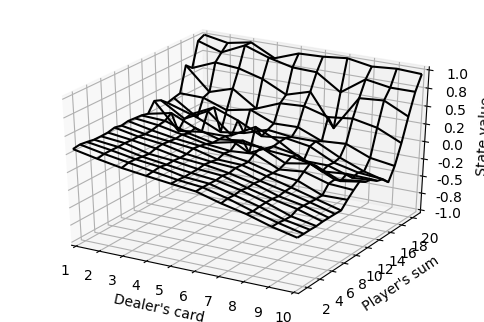

In [12]:
fig = plt.figure(dpi=100)#figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
state_value_wireframe(ax, mc_q.max(axis=-1))
# plt.savefig('example.pdf')
# plt.savefig('example.pgf')
plt.show()

## SARSA($\lambda$)

<img src="images/sarsa_lambda.png" width="600">

In [8]:
class NPDecayingEpsilonGreedyPolicy(object):
    def __init__(self, env, qpi, n_zero=100):
        self._qpi = qpi
        self._n_zero = n_zero
        self._state_action_count = np.zeros(
            states_actions_shape(env), dtype=np.int32)
        self._random = random.Random()
        self._random.seed(5788)
        
    def __call__(self, state):
        state_visits = self._state_action_count[state].sum().item() + 1
        epsilon = self._n_zero / (self._n_zero + state_visits)
        if self._random.random() < epsilon:
            action = self._random.randrange(2)
        else:
            action = self._qpi[state].argmax().item()
        self._state_action_count[state][action] += 1
        return action
    
    def times_taken(self, state, action):
        return self._state_action_count[state][action]
    
def sarsa_lambda(env, episodes, *, lam=0, callback=None):
    # Initialize all state values to 0
    qpi = np.zeros(states_actions_shape(env))
    # Initialize decaying epsilon greedy policy
    policy = NPDecayingEpsilonGreedyPolicy(env, qpi)
    
    for episode in tnrange(episodes, desc='Progress', unit='episodes'):
        eligibility = np.zeros(states_actions_shape(env))
        done, state = False, env.reset()
        action = policy(state)
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action = policy(next_state)
            next_state_action_value = 0 if done else qpi[next_state][next_action]
            delta = reward + next_state_action_value - qpi[state][action]
            eligibility[state][action] += 1
            
            indexes = eligibility > 0
            alpha = 1 / policy._state_action_count[indexes]
            qpi[indexes] += alpha * delta * eligibility[indexes]
            eligibility[indexes] *= lam

            state, action = next_state, next_action

        if callback is not None:
            callback(qpi)

    return qpi

In [9]:
env.seed(5788)
sarsa_q = sarsa_lambda(env, int(1e6), lam=.2)

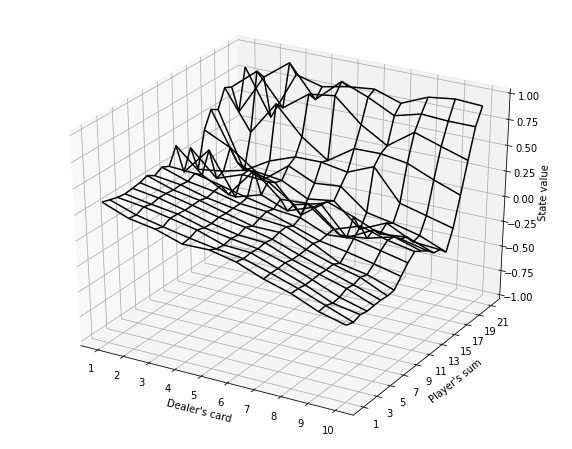

In [10]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
state_value_wireframe(ax, sarsa_q.max(axis=-1))

## Q-Learning

In [11]:
def q_learning(env, episodes):
    # Initialize all state values to 0
    qmu = dict.fromkeys(all_state_action_pairs(env), 0)
    # Initialize decaying epsilon greedy policy
    policy = DecayingEpsilonGreedyPolicy(env, qmu)
    
    for episode in tnrange(episodes, desc='Progress', unit='episodes'):
        done, state = False, env.reset()
        while not done:
            action = policy(state)
            policy.update_count(state, action)
            next_state, reward, done, _ = env.step(action)

            max_next_q_value = 0 if done else max(
                qmu[next_state, action] for action in all_actions(env))
            delta = reward + max_next_q_value - qmu[state, action]
            alpha = 1 / policy.times_taken(state, action)
            qmu[state, action] += alpha * delta

            state = next_state

    return qpi_array_from_dict(qmu)

In [12]:
env.seed(5788)
qstar = q_learning(env, int(1e6))

In [13]:
import seaborn as sns
from matplotlib import cm

def plot_final_policy_value(qstar):
    pistar = qstar.argmax(axis=-1)
    vstar = qstar.max(axis=-1)

    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_title('optimal value', fontsize=16)
    state_value_wireframe(ax, vstar)
#     ax.view_init(30, 300)

    ax = fig.add_subplot(1, 2, 2)
    fig = sns.heatmap(np.flipud(pistar.transpose()), ax=ax, cmap="YlGnBu",
                      xticklabels=range(1,11), yticklabels=range(21,0,-1))
    fig.set_xlabel("Dealer's card", fontsize=10)
    fig.set_ylabel("Player's sum", fontsize=10)
    fig.set_title('optimal policy', fontsize=16)

    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    plt.savefig('example.pdf')
    plt.savefig('example.pgf')
    plt.show()

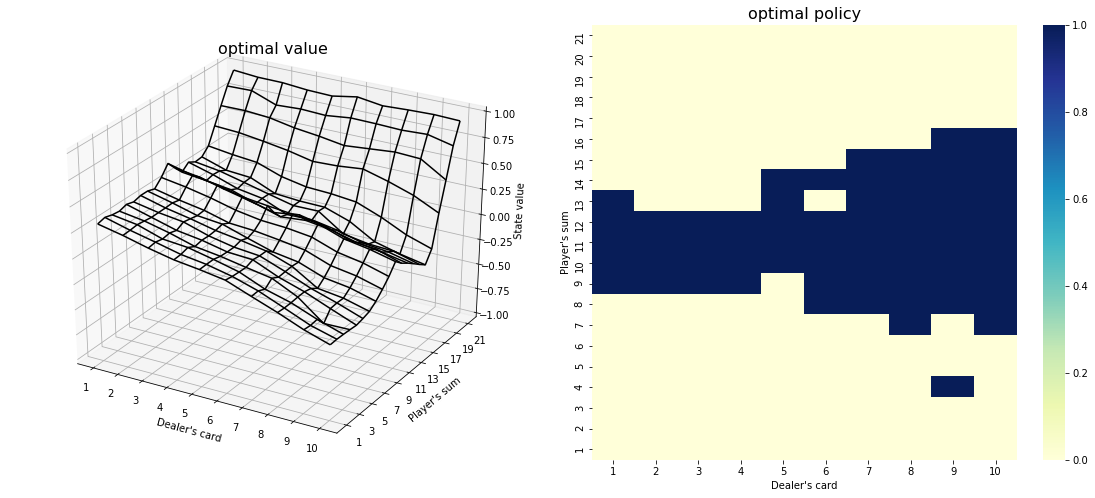

In [14]:
plot_final_policy_value(qstar)

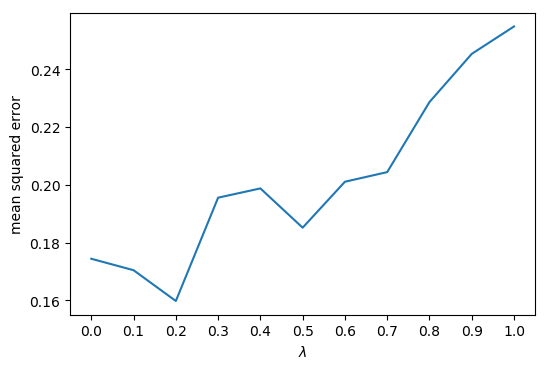

In [15]:
errors = []
lambdas = tuple(x/10 for x in range(11))
for lam in lambdas:
    env.seed(5788)
    qlam = sarsa_lambda(env, 1000, lam=lam)
    errors.append(np.square(qlam - qstar).mean())
    
fig = plt.figure(dpi=100)#figsize=(8,6))
plt.plot(lambdas, errors)
plt.xticks(lambdas)
plt.xlabel("$\lambda$")#, fontsize=16)
plt.ylabel("mean squared error")#, fontsize=16)
plt.show()

In [16]:
env.seed(5788)
sarsa_lam02_q = sarsa_lambda(env, 100000, lam=0.2)

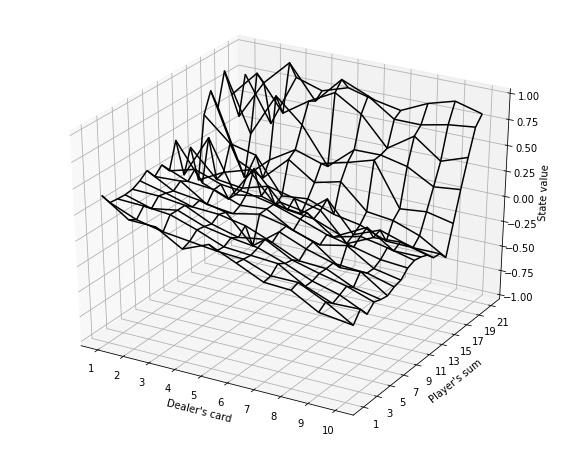

In [17]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
state_value_wireframe(ax, sarsa_lam02_q.max(axis=-1))

In [18]:
errors0 = []
def callback(qpi):
    errors0.append(np.square(qpi - qstar).mean())
env.seed(5788)
_ = sarsa_lambda(env, int(1e5), lam=0, callback=callback)

errors1 = []
def callback(qpi):
    errors1.append(np.square(qpi - qstar).mean())
env.seed(5788)
_ = sarsa_lambda(env, int(1e5), lam=1, callback=callback)

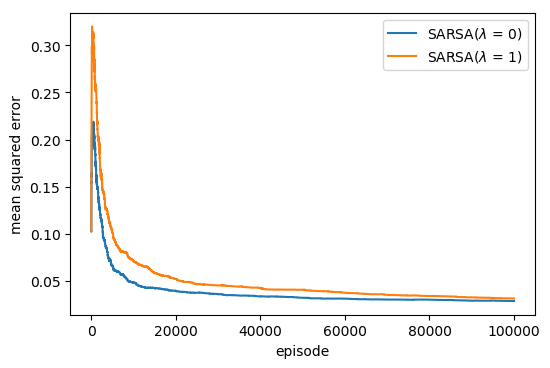

In [19]:
fig = plt.figure(dpi=100)#figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(1, int(1e5)+1), errors0, '-', label='SARSA($\lambda$ = 0)')
ax.plot(range(1, int(1e5)+1), errors1, '-', label='SARSA($\lambda$ = 1)')
ax.set_xlabel('episode')#, fontsize=16)
ax.set_ylabel('mean squared error')#, fontsize=16)
# ax.tick_params(labelsize="large")
ax.legend()
plt.show()